## Predictors Wrangling
Implementing missing sensor streams and removing NAs

In [1]:
import pandas as pd 
import os

#path to raw data
DATA_PATH = '/home/jmocel/trelium/rapids/data/raw'

for (root,dirs,files) in os.walk(DATA_PATH):
    total = pd.DataFrame()
    for dir in dirs:
        if dir.startswith('p'):
            raw_df = pd.read_csv(os.path.join(DATA_PATH,dir,'phone_screen_with_datetime.csv'))
            raw_df = raw_df[['assigned_segments','screen_status']]
            raw_df['assigned_segments'] = [i.split(';')[0] + ']' for i in raw_df['assigned_segments']]
            #add pid column
            raw_df['pid'] = dir
            total = pd.concat([total, raw_df], ignore_index=True )
    break        

total

,assigned_segments,screen_status,pid
0,"[onehour0008#2019-01-29 08:00:00,2019-01-29 08...",0,p154
1,"[onehour0009#2019-01-29 09:00:00,2019-01-29 09...",0,p154
2,"[onehour0009#2019-01-29 09:00:00,2019-01-29 09...",1,p154
3,"[onehour0009#2019-01-29 09:00:00,2019-01-29 09...",1,p154
4,"[onehour0009#2019-01-29 09:00:00,2019-01-29 09...",1,p154
...,...,...,...
101682,"[onehour0022#2020-07-22 22:00:00,2020-07-22 22...",0,p255
101683,"[onehour0022#2020-07-22 22:00:00,2020-07-22 22...",1,p255
101684,"[onehour0022#2020-07-22 22:00:00,2020-07-22 22...",0,p255
101685,"[onehour0022#2020-07-22 22:00:00,2020-07-22 22...",0,p255


In [2]:
#build screen features 
phone_screen_rapids_countepisodeunlock = total.groupby(['pid','assigned_segments']).count()
phone_screen_rapids_countepisodeunlock = phone_screen_rapids_countepisodeunlock.reset_index(level=[0,1])
phone_screen_rapids_countepisodeunlock.columns = [*phone_screen_rapids_countepisodeunlock.columns[:-1], 'phone_screen_countepisodeunlock']
phone_screen_rapids_countepisodeunlock


,pid,assigned_segments,phone_screen_countepisodeunlock
0,p102,"[onehour0000#2018-10-12 00:00:00,2018-10-12 00...",3
1,p102,"[onehour0000#2018-10-13 00:00:00,2018-10-13 00...",1
2,p102,"[onehour0000#2018-10-14 00:00:00,2018-10-14 00...",5
3,p102,"[onehour0000#2018-10-16 00:00:00,2018-10-16 00...",1
4,p102,"[onehour0000#2018-10-19 00:00:00,2018-10-19 00...",3
...,...,...,...
14488,p400,"[onehour0023#2021-02-07 23:00:00,2021-02-07 23...",2
14489,p400,"[onehour0023#2021-02-09 23:00:00,2021-02-09 23...",2
14490,p400,"[onehour0023#2021-02-10 23:00:00,2021-02-10 23...",2
14491,p400,"[onehour0023#2021-02-11 23:00:00,2021-02-11 23...",2


In [3]:
import pandas as pd 

#Imputing with 0 those time segments for which minutely data yield is greater than 0.2

#read complete feature matrix 
allfeats = pd.read_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/all_sensor_features_orig.csv')

# substituting phone_screen_rapids_countepisodeunlock with that previouly computed 
phone_screen_rapids_countepisodeunlock['assigned_segments'] = [i[1:-1] for i in phone_screen_rapids_countepisodeunlock['assigned_segments']]
allfeats  = pd.merge(allfeats, phone_screen_rapids_countepisodeunlock, left_on= ['pid', 'local_segment'], right_on = [ 'pid','assigned_segments'], how='outer')

#remove undesired columns having no data 
allfeats = allfeats.drop(columns=['assigned_segments',
'phone_screen_rapids_stddurationunlock', #mostly NA for phone screen
 'phone_screen_rapids_sumdurationunlock',
 'phone_screen_rapids_countepisodeunlock',
 'phone_screen_rapids_firstuseafter01unlock',
 'phone_screen_rapids_avgdurationunlock',
 'phone_screen_rapids_mindurationunlock',
 'phone_screen_rapids_maxdurationunlock',
 'phone_accelerometer_panda_stddurationexertionalactivityepisode', #highly correlated with phone_accelerometer_panda_avgdurationexertionalactivityepisode
 'phone_accelerometer_panda_sumdurationexertionalactivityepisode',	
 'phone_accelerometer_panda_maxdurationexertionalactivityepisode',
'phone_accelerometer_panda_mindurationexertionalactivityepisode',
'phone_accelerometer_panda_mediandurationexertionalactivityepisode',
'phone_accelerometer_panda_sumdurationnonexertionalactivityepisode', #highly correlated
'phone_accelerometer_panda_maxdurationnonexertionalactivityepisode',
'phone_accelerometer_panda_mindurationnonexertionalactivityepisode',
'phone_accelerometer_panda_mediandurationnonexertionalactivityepisode',
'phone_accelerometer_panda_stddurationnonexertionalactivityepisode',
 'phone_data_yield_rapids_ratiovalidyieldedhours',
'phone_bluetooth_rapids_countscans', #duplicate of doryab 
 'phone_bluetooth_rapids_uniquedevices',
 'phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsall', #not useful 
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsall',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrossdatasetall',
 'phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsall',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsall',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrossdatasetall',
 'phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsown',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsown',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrossdatasetown',
 'phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsown',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsown',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrossdatasetown',
 'phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsothers',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsothers',
  'phone_bluetooth_doryab_countscansmostfrequentdeviceacrossdatasetothers',
 'phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsothers',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsothers',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrossdatasetothers',
 'phone_wifi_visible_rapids_countscans',
 'phone_light_rapids_count',
 'phone_light_rapids_medianlux',
  'phone_accelerometer_rapids_medianmagnitude',
  'phone_accelerometer_panda_validsensedminutes',
 'phone_battery_rapids_countdischarge',#redundant, similar to duration 
 'phone_battery_rapids_countcharge',#redundant
  'phone_bluetooth_doryab_countscansothers', #perfect collinearity with others 
 'phone_bluetooth_doryab_uniquedevicesothers',
 'phone_bluetooth_doryab_meanscansothers',
 'phone_bluetooth_doryab_stdscansothers'
 ],inplace=False)

columns_to_impute = [ 
 #'phone_screen_countepisodeunlock',
 'phone_wifi_visible_rapids_uniquedevices',
 'phone_wifi_visible_rapids_countscansmostuniquedevice',
 #'phone_battery_rapids_countdischarge',
 #'phone_battery_rapids_sumdurationdischarge',
 #'phone_battery_rapids_avgconsumptionrate',
 #'phone_battery_rapids_maxconsumptionrate',
 #'phone_battery_rapids_countcharge',
 #'phone_battery_rapids_sumdurationcharge',
 'phone_bluetooth_rapids_countscansmostuniquedevice',
 'phone_bluetooth_doryab_countscansall',
 'phone_bluetooth_doryab_uniquedevicesall',
 'phone_bluetooth_doryab_meanscansall',
 'phone_bluetooth_doryab_stdscansall',
 'phone_bluetooth_doryab_countscansown',
 'phone_bluetooth_doryab_uniquedevicesown',
 'phone_bluetooth_doryab_meanscansown',
 'phone_bluetooth_doryab_stdscansown'
]

cols_activity = [
 'phone_activity_recognition_rapids_mostcommonactivity',
 #'phone_activity_recognition_rapids_count',
 #'phone_activity_recognition_rapids_countuniqueactivities',
 #'phone_activity_recognition_rapids_durationstationary',
 #'phone_activity_recognition_rapids_durationmobile',
 #'phone_activity_recognition_rapids_durationvehicle'
 ]

cols_std_var = [ #coluns that have nan due to std computed by dividing over n-1
'phone_bluetooth_doryab_stdscansall',
'phone_bluetooth_doryab_stdscansown',
'phone_locations_doryab_loglocationvariance']

#allfeats.columns = allfeats.columns.to_series().apply(lambda x: x.strip()) #remove spaces in names of columns 
for column in columns_to_impute:
    allfeats.loc[(allfeats['phone_data_yield_rapids_ratiovalidyieldedminutes']>=0.4) & allfeats[column].isnull(), [column]] = 0

for column in cols_activity:
    allfeats.loc[(allfeats['phone_data_yield_rapids_ratiovalidyieldedminutes']>=0.4) & allfeats[column].isnull(), [column]] = 4  #insert "unknown activity"

allfeats[cols_std_var] = allfeats[cols_std_var].fillna(0) #because the computation of the sd uses n-1 as denom, yielding na when there is only 1 obs. 



In [4]:
#remove rows where there are too many missing values 
# Delete rows containing either perc or more than perc NaN Values
perc = 40
min_count =  int(((100-perc)/100)*allfeats.shape[1] + 1)
#allfeats.dropna(thresh=min_count, inplace = True)


In [5]:
#remove columns with zero variance without considering NAs
set(allfeats.columns)- set(allfeats.loc[:,allfeats.apply(pd.Series.nunique) != 1].columns)
allfeats = allfeats.loc[:,allfeats.apply(pd.Series.nunique) != 1]

#additionally drop a column that is constant for 11 participants 
#allfeats.drop(columns=['phone_bluetooth_doryab_stdscansown'], inplace = True)

In [6]:
allfeats['sort'] = allfeats['pid'].str.extract('(\d+)', expand=False).astype(int)


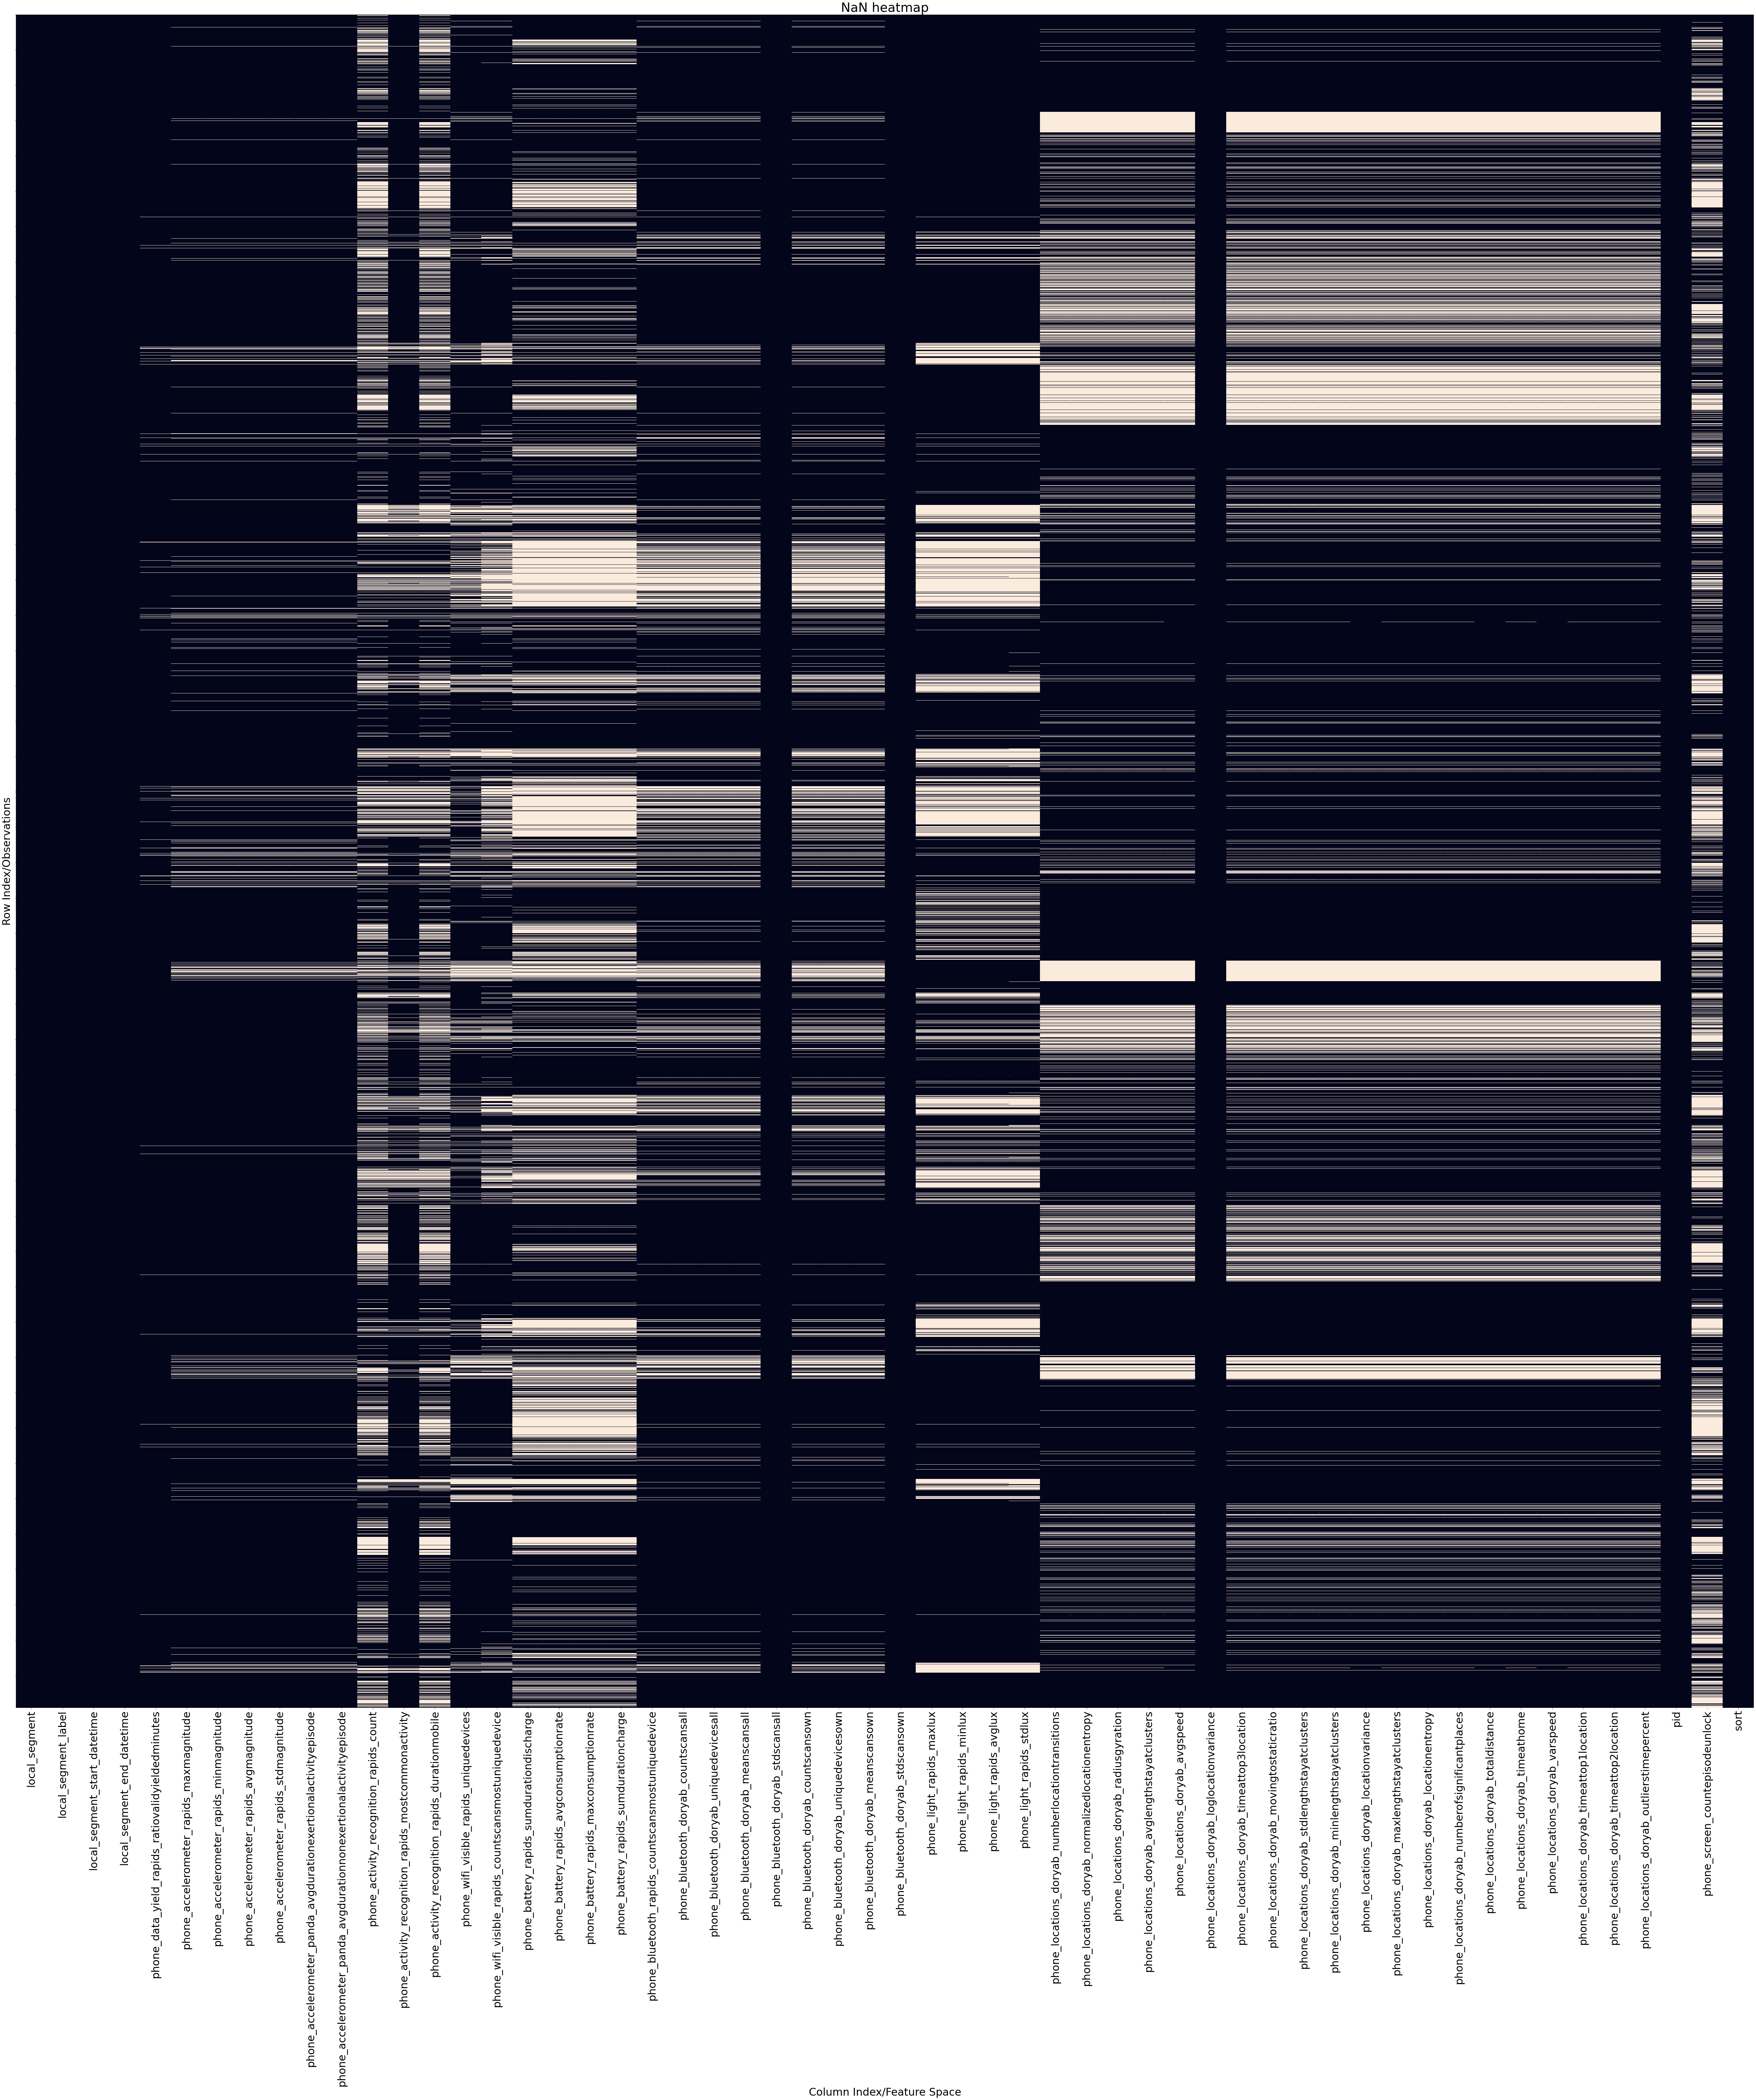

In [7]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({'font.size': 34})

#load dataframe
listings= allfeats.sort_values('sort')
#set figure size
plt.figure(figsize=(100,100))

#generate heatmap
sns.heatmap(listings.isnull(), cbar=False)

#labels and titles
plt.title("NaN heatmap")
plt.yticks(np.arange(0, listings.shape[0], 500))
plt.xlabel("Column Index/Feature Space")
plt.ylabel("Row Index/Observations")

#save to file
plt.savefig("nan_feats_allpart_fetselect_onehour_biglabels")

plt.show()

In [11]:
exp_wait_split = {
'p102': 'EG', 
'p104': 'EG', 
'p124': 'EG', 
'p131': 'WL',
'p134': 'EG',
'p141': 'EG',
'p149': 'EG', 
'p154': 'EG', 
'p166': 'EG', 
'p170': 'EG', 
'p181': 'EG', 
'p194': 'EG', 
'p201': 'EG', 
'p208': 'WL', 
'p230': 'EG',
'p255': 'EG',
'p261': 'EG',
'p262': 'WL',
'p263': 'EG', 
'p265': 'EG', 
'p273': 'EG', 
'p284': 'WL', 
'p310': 'EG', 
'p319': 'WL', 
'p326': 'EG', 
'p333': 'EG', 
'p355': 'EG', 
'p366': 'WL', 
'p369': 'EG', 
'p376': 'WL', #None #didn't start therapy sessions
'p383': 'EG', 
'p393': 'WL', 
'p400': 'EG'
}



In [12]:
#also add target questionnaire values 
targets = pd.read_csv('/home/jmocel/trelium/OPTIMAX-sensing/processed_data/questionnaireGT_final.csv')
targets = targets.drop(labels=['HAMA_PRE_SEVERITY','HAMA_MID_SEVERITY','HAMA_POST_SEVERITY'], axis=1)
#time intervals of sensing for all participants 
segments = pd.read_csv('/home/jmocel/trelium/OPTIMAX-sensing/processed_data/AllSensingParticipants.csv')

#build period column stating whether the time segment is from pre mid or post 
oasis, bai, hama, period, group = ([],[],[],[],[])
percentage_change_hama,percentage_change_oasis,percentage_change_bai = ([],[],[])
oasis_nonclinical_post,bai_nonclinical_post,hama_nonclinical_post = ([],[],[])

allfeats['segment_end_date'] = pd.to_datetime(allfeats['local_segment_end_datetime']).dt.date
segments['end_date'] = pd.to_datetime(segments['end_date']).dt.date + pd.Timedelta(days=25)
segments['start_date ']= pd.to_datetime(segments['start_date ']).dt.date + pd.Timedelta(days=-25)

for i in range(allfeats.shape[0]):
    participant = int(allfeats.iloc[i]['pid'][1:])
    group.append(exp_wait_split['p'+str(participant)])
    #1 treatment outcome  as using percentage change scores for pre- minus post-treatment scores/Baseline*100 (%∆OASIS, %∆BAI and %∆HAM-A)
    percentage_change_hama.append(targets.loc[(targets['VP']==participant),['HAMA_perc_change']].iloc[0,0])
    percentage_change_oasis.append(targets.loc[(targets['VP']==participant),['OASIS_perc_change']].iloc[0,0])
    percentage_change_bai.append(targets.loc[(targets['VP']==participant),['BAI_perc_change']].iloc[0,0])
    #2 add column “end of treatment score is comparable to non clinical population” 1-hot
    hama_nonclinical_post.append(targets.loc[(targets['VP']==participant),['HAMA_POST_nonclinical']].iloc[0,0])
    bai_nonclinical_post.append(targets.loc[(targets['VP']==participant),['BAI_POST_nonclinical']].iloc[0,0])
    oasis_nonclinical_post.append(targets.loc[(targets['VP']==participant),['OASIS_POST_nonclinical']].iloc[0,0])
        
    if allfeats.iloc[i]['segment_end_date'] <= segments.loc[(segments['pid ']==participant),['end_date']].iloc[0].item() and allfeats.iloc[i]['segment_end_date'] >= segments.loc[(segments['pid ']==participant),['start_date ']].iloc[0].item():
        #pre
        oasis.append(targets.loc[(targets['VP']==participant),['OASIS_PRE']].iloc[0,0])
        hama.append(targets.loc[(targets['VP']==participant),['HAMA_PRE']].iloc[0,0])
        bai.append(targets.loc[(targets['VP']==participant),['BAI_PRE']].iloc[0,0])
        period.append('PRE')
    elif allfeats.iloc[i]['segment_end_date'] <= segments.loc[(segments['pid ']==participant),['end_date']].iloc[1].item() and allfeats.iloc[i]['segment_end_date'] >= segments.loc[(segments['pid ']==participant),['start_date ']].iloc[1].item():
        #mid
        oasis.append(targets.loc[(targets['VP']==participant),['OASIS_MID']].iloc[0,0])
        hama.append(targets.loc[(targets['VP']==participant),['HAMA_MID']].iloc[0,0])
        bai.append(targets.loc[(targets['VP']==participant),['BAI_MID']].iloc[0,0])
        period.append('MID')
    elif allfeats.iloc[i]['segment_end_date'] <= segments.loc[(segments['pid ']==participant),['end_date']].iloc[2].item() and allfeats.iloc[i]['segment_end_date'] >= segments.loc[(segments['pid ']==participant),['start_date ']].iloc[2].item():
        #post
        oasis.append(targets.loc[(targets['VP']==participant),['OASIS_POST']].iloc[0,0])
        hama.append(targets.loc[(targets['VP']==participant),['HAMA_POST']].iloc[0,0])
        bai.append(targets.loc[(targets['VP']==participant),['BAI_POST']].iloc[0,0])
        period.append('POST')
    else:
        print(allfeats.iloc[i]['segment_end_date'])
        print(participant)
        print(segments.loc[(segments['pid ']==participant),['start_date ','end_date']])
        break
        #oasis.append(pd.NA)
        #hama.append(pd.NA)
        #bai.append(pd.NA)



In [13]:
allfeats['OASIS'] = oasis
allfeats['BAI'] = bai
allfeats['HAMA'] = hama
allfeats['sensing_period'] = period
allfeats['exp_group'] = group
allfeats['percentage_change_hama'] = percentage_change_hama
allfeats['percentage_change_oasis'] = percentage_change_oasis
allfeats['percentage_change_bai'] = percentage_change_bai
allfeats['hama_nonclinical_post'] = hama_nonclinical_post
allfeats['bai_nonclinical_post'] = bai_nonclinical_post
allfeats['oasis_nonclinical_post'] = oasis_nonclinical_post

In [14]:
allfeats.to_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/sel_sensor_features_nas.csv')

### Code to add target variables

In [4]:
#standalone code to add target variables to data matrix in case this was not previously done
import pandas as pd
targets = pd.read_csv('/home/jmocel/trelium/OPTIMAX-sensing/processed_data/questionnaireGT_final.csv')
targets = targets.drop(labels=['HAMA_PRE_SEVERITY','HAMA_MID_SEVERITY','HAMA_POST_SEVERITY'], axis=1)
allfeats = pd.read_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/all_sensor_features_clean_withtarget.csv')

percentage_change_hama,percentage_change_oasis,percentage_change_bai = ([],[],[])
oasis_nonclinical_post,bai_nonclinical_post,hama_nonclinical_post = ([],[],[])

for i in range(allfeats.shape[0]):
    participant = int(allfeats.iloc[i]['pid'][1:])
    #1 treatment outcome  as using percentage change scores for pre- minus post-treatment scores/Baseline*100 (%∆OASIS, %∆BAI and %∆HAM-A)
    percentage_change_hama.append(targets.loc[(targets['VP']==participant),['HAMA_perc_change']].iloc[0,0])
    percentage_change_oasis.append(targets.loc[(targets['VP']==participant),['OASIS_perc_change']].iloc[0,0])
    percentage_change_bai.append(targets.loc[(targets['VP']==participant),['BAI_perc_change']].iloc[0,0])
    #2 add column “end of treatment score is comparable to non clinical population” 1-hot
    hama_nonclinical_post.append(targets.loc[(targets['VP']==participant),['HAMA_POST_nonclinical']].iloc[0,0])
    bai_nonclinical_post.append(targets.loc[(targets['VP']==participant),['BAI_POST_nonclinical']].iloc[0,0])
    oasis_nonclinical_post.append(targets.loc[(targets['VP']==participant),['OASIS_POST_nonclinical']].iloc[0,0])

allfeats['percentage_change_hama'] = percentage_change_hama
allfeats['percentage_change_oasis'] = percentage_change_oasis
allfeats['percentage_change_bai'] = percentage_change_bai
allfeats['hama_nonclinical_post'] = hama_nonclinical_post
allfeats['bai_nonclinical_post'] = bai_nonclinical_post
allfeats['oasis_nonclinical_post'] = oasis_nonclinical_post

### Code to only add rci variables

In [15]:
#standalone code to add target variables to data matrix in case this was not previously done
import pandas as pd
targets = pd.read_csv('/home/jmocel/trelium/OPTIMAX-sensing/processed_data/questionnaireGT_final.csv')
targets = targets.drop(labels=['HAMA_PRE_SEVERITY','HAMA_MID_SEVERITY','HAMA_POST_SEVERITY'], axis=1)
#allfeats = pd.read_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/all_sensor_features_clean_withtarget.csv')
allfeats = pd.read_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/sel_sensor_features_nas.csv')

responder_oasis_rci,responder_bai_rci,responder_hama_rci,responder_rci = ([],[],[],[])

for i in range(allfeats.shape[0]):
    participant = int(allfeats.iloc[i]['pid'][1:])
    #1 treatment outcome as measured by rci
    responder_oasis_rci.append(targets.loc[(targets['VP']==participant),['OASIS_RCI_responder']].iloc[0,0])
    responder_bai_rci.append(targets.loc[(targets['VP']==participant),['BAI_RCI_responder']].iloc[0,0])
    responder_hama_rci.append(targets.loc[(targets['VP']==participant),['HAMA_RCI_responder']].iloc[0,0])
    responder_rci.append(targets.loc[(targets['VP']==participant),['RCI_responder']].iloc[0,0])
    
allfeats['OASIS_RCI_responder'] = responder_oasis_rci
allfeats['BAI_RCI_responder'] = responder_bai_rci
allfeats['HAMA_RCI_responder'] = responder_hama_rci
allfeats['RCI_responder'] = responder_rci


In [19]:
#in this version of the dataset, before saving we also assign p376 to waitlist and not to None 
allfeats.loc[allfeats['pid']=='p376',['exp_group']] = 'WL'

In [16]:
#Extend or truncate every labelled time series to match the 14 days 22h duration
from datetime import timedelta
import pandas as pd
from numpy.random import normal 
import numpy as np

def uniform_windows(df):
    #Extend or truncate every labelled time series to match the 14 days 22h duration
    df['local_segment_start_datetime'] = pd.to_datetime(df['local_segment_start_datetime'], infer_datetime_format = True)

    minimums = df.groupby(['pid','sensing_period'])['local_segment_start_datetime'].min()
    maximums = df.groupby(['pid','sensing_period'])['local_segment_start_datetime'].max()

    #anything that is shorter than the 14 days 22 h window gets padded with white noise    
    #arbitrarily add 14 d 22 h of white noise to each participant and then cut it 
    vals = []
    """
    for i in df.columns:
        #column = normal(size=1000) #358 hourly segments 
        vals.append(column)
    padding = pd.DataFrame(dict(zip(df.columns, vals)), index = [0])

    """
    column = np.empty((1000,allfeats.shape[1]))
    column[:] = np.NaN
    padding = pd.DataFrame(column,columns = df.columns)

    for part in df['pid'].unique():
        for period in df.loc[df['pid']==part, 'sensing_period'].unique(): #pad pre, mid, post 
            npresent = len(df.loc[(df['pid']==part) & (df['sensing_period']==period)])
            inde = 358-npresent
            if inde>0: #needs padding
                padding['pid'] = part
                padding['sensing_period'] = period
                #generate a list of 14 days worth of hourly segments to use as local_segment_start_datetime column 
                base = maximums[(part,period)]
                padding['local_segment_start_datetime'] = [base + pd.Timedelta(hours=x) for x in range(1,padding.shape[0]+1)]
                df = pd.concat([df,padding.iloc[:inde,:]], ignore_index = True)
            
            if inde<0: #needs truncation
                #print(inde)
                #indexo = list(df.loc[(df['pid']==part)].index)
                #df.drop(indexo[358:], inplace=True)
                temp = df.loc[(df['pid']==part)&(df['sensing_period']==period)]
                df.drop(df.loc[(df['pid']==part)&(df['sensing_period']==period)].index, inplace=True)
                df = pd.concat([df,temp.head(358)], ignore_index = True)
            

    return df

allfeats = uniform_windows(allfeats)

In [17]:

#allfeats.to_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/all_sensor_features_clean_withtarget_all_rci.csv')
allfeats.to_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/sel_sensor_features_nas_withtarget.csv')

### visualize features correlation 


In [12]:
#visualize features correlation 
import pandas as pd
df = pd.read_csv('/home/jmocel/trelium/rapids/data/data/processed/features/all_participants/all_sensor_features_nas_withtarget.csv')
#excluded_cols = ['sensing_period','exp_group','Unnamed: 0','pid','segment_end_date','local_segment','local_segment_label','local_segment_start_datetime','local_segment_end_datetime','phone_data_yield_rapids_ratiovalidyieldedminutes','phone_data_yield_rapids_ratiovalidyieldedhours'] #'HAMA','OASIS','BAI'
#df = df.drop(columns=excluded_cols)
keep = [
 'phone_bluetooth_rapids_countscansmostuniquedevice',
 'phone_bluetooth_doryab_countscansall',
 'phone_bluetooth_doryab_uniquedevicesall',
 'phone_bluetooth_doryab_meanscansall',
 'phone_bluetooth_doryab_stdscansall',

 'phone_bluetooth_doryab_countscansown',
 'phone_bluetooth_doryab_uniquedevicesown',
 'phone_bluetooth_doryab_meanscansown',

 'phone_bluetooth_doryab_countscansothers',
 'phone_bluetooth_doryab_uniquedevicesothers',
 'phone_bluetooth_doryab_meanscansothers',
 'phone_bluetooth_doryab_stdscansothers',
 ]

exc_bluetooth = [ 'phone_bluetooth_rapids_countscans',
 'phone_bluetooth_rapids_uniquedevices',
    'phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsall',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsall',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrossdatasetall',
 'phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsall',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsall',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrossdatasetall',
  'phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsown',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsown',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrossdatasetown',
 'phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsown',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsown',
 'phone_bluetooth_doryab_countscansmostfrequentdevicewithinsegmentsothers',
 'phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsothers',
 'phone_bluetooth_doryab_countscansleastfrequentdevicewithinsegmentsothers',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsothers',
 'phone_bluetooth_doryab_countscansleastfrequentdeviceacrossdatasetothers'
 ]
df = df[keep]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,phone_bluetooth_rapids_countscansmostuniquedevice,phone_bluetooth_doryab_countscansall,phone_bluetooth_doryab_uniquedevicesall,phone_bluetooth_doryab_meanscansall,phone_bluetooth_doryab_stdscansall,phone_bluetooth_doryab_countscansown,phone_bluetooth_doryab_uniquedevicesown,phone_bluetooth_doryab_meanscansown,phone_bluetooth_doryab_countscansothers,phone_bluetooth_doryab_uniquedevicesothers,phone_bluetooth_doryab_meanscansothers,phone_bluetooth_doryab_stdscansothers
phone_bluetooth_rapids_countscansmostuniquedevice,1.000000,0.254761,0.051239,0.619831,0.821519,0.736359,0.139592,0.893142,0.120059,0.041509,0.283258,0.282428
phone_bluetooth_doryab_countscansall,0.254761,1.000000,0.874899,0.336291,0.249422,0.277487,0.185587,0.237454,0.982195,0.866776,0.385623,0.283400
phone_bluetooth_doryab_uniquedevicesall,0.051239,0.874899,1.000000,0.134011,0.040704,0.077484,0.118475,0.051648,0.891643,0.997448,0.215889,0.094753
phone_bluetooth_doryab_meanscansall,0.619831,0.336291,0.134011,1.000000,0.811912,0.710402,0.327732,0.701006,0.209636,0.111248,0.761151,0.578088
phone_bluetooth_doryab_stdscansall,0.821519,0.249422,0.040704,0.811912,1.000000,0.740389,0.141655,0.863756,0.113736,0.030763,0.465900,0.513470
phone_bluetooth_doryab_countscansown,0.736359,0.277487,0.077484,0.710402,0.740389,1.000000,0.625706,0.816858,0.092060,0.032960,0.419502,0.307952
phone_bluetooth_doryab_uniquedevicesown,0.139592,0.185587,0.118475,0.327732,0.141655,0.625706,1.000000,0.217911,0.070000,0.047285,0.335920,0.121090
phone_bluetooth_doryab_meanscansown,0.893142,0.237454,0.051648,0.701006,0.863756,0.816858,0.217911,1.000000,0.086379,0.036289,0.336270,0.283818
phone_bluetooth_doryab_countscansothers,0.120059,0.982195,0.891643,0.209636,0.113736,0.092060,0.070000,0.086379,1.000000,0.891930,0.317650,0.233514
phone_bluetooth_doryab_uniquedevicesothers,0.041509,0.866776,0.997448,0.111248,0.030763,0.032960,0.047285,0.036289,0.891930,1.000000,0.193025,0.086613


In [14]:
corr.where((corr>0.4) | (corr < -0.4), 0, inplace = True)

corr.style.background_gradient(cmap='coolwarm')


,phone_bluetooth_rapids_countscansmostuniquedevice,phone_bluetooth_doryab_countscansall,phone_bluetooth_doryab_uniquedevicesall,phone_bluetooth_doryab_meanscansall,phone_bluetooth_doryab_stdscansall,phone_bluetooth_doryab_countscansown,phone_bluetooth_doryab_uniquedevicesown,phone_bluetooth_doryab_meanscansown,phone_bluetooth_doryab_countscansothers,phone_bluetooth_doryab_uniquedevicesothers,phone_bluetooth_doryab_meanscansothers,phone_bluetooth_doryab_stdscansothers
phone_bluetooth_rapids_countscansmostuniquedevice,1.000000,0.000000,0.000000,0.619831,0.821519,0.736359,0.000000,0.893142,0.000000,0.000000,0.000000,0.000000
phone_bluetooth_doryab_countscansall,0.000000,1.000000,0.874899,0.000000,0.000000,0.000000,0.000000,0.000000,0.982195,0.866776,0.000000,0.000000
phone_bluetooth_doryab_uniquedevicesall,0.000000,0.874899,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.891643,0.997448,0.000000,0.000000
phone_bluetooth_doryab_meanscansall,0.619831,0.000000,0.000000,1.000000,0.811912,0.710402,0.000000,0.701006,0.000000,0.000000,0.761151,0.578088
phone_bluetooth_doryab_stdscansall,0.821519,0.000000,0.000000,0.811912,1.000000,0.740389,0.000000,0.863756,0.000000,0.000000,0.465900,0.513470
phone_bluetooth_doryab_countscansown,0.736359,0.000000,0.000000,0.710402,0.740389,1.000000,0.625706,0.816858,0.000000,0.000000,0.419502,0.000000
phone_bluetooth_doryab_uniquedevicesown,0.000000,0.000000,0.000000,0.000000,0.000000,0.625706,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
phone_bluetooth_doryab_meanscansown,0.893142,0.000000,0.000000,0.701006,0.863756,0.816858,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
phone_bluetooth_doryab_countscansothers,0.000000,0.982195,0.891643,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.891930,0.000000,0.000000
phone_bluetooth_doryab_uniquedevicesothers,0.000000,0.866776,0.997448,0.000000,0.000000,0.000000,0.000000,0.000000,0.891930,1.000000,0.000000,0.000000


In [ ]:
import pandas as pd
targets = pd.read_csv('/home/jmocel/trelium/OPTIMAX-sensing/processed_data/questionnaireGT_final.csv')
targets = targets.drop(labels=['HAMA_PRE_SEVERITY','HAMA_MID1_SEVERITY','HAMA_POST_SEVERITY'], axis=1)

targets['OASIS_PRE'].plot()

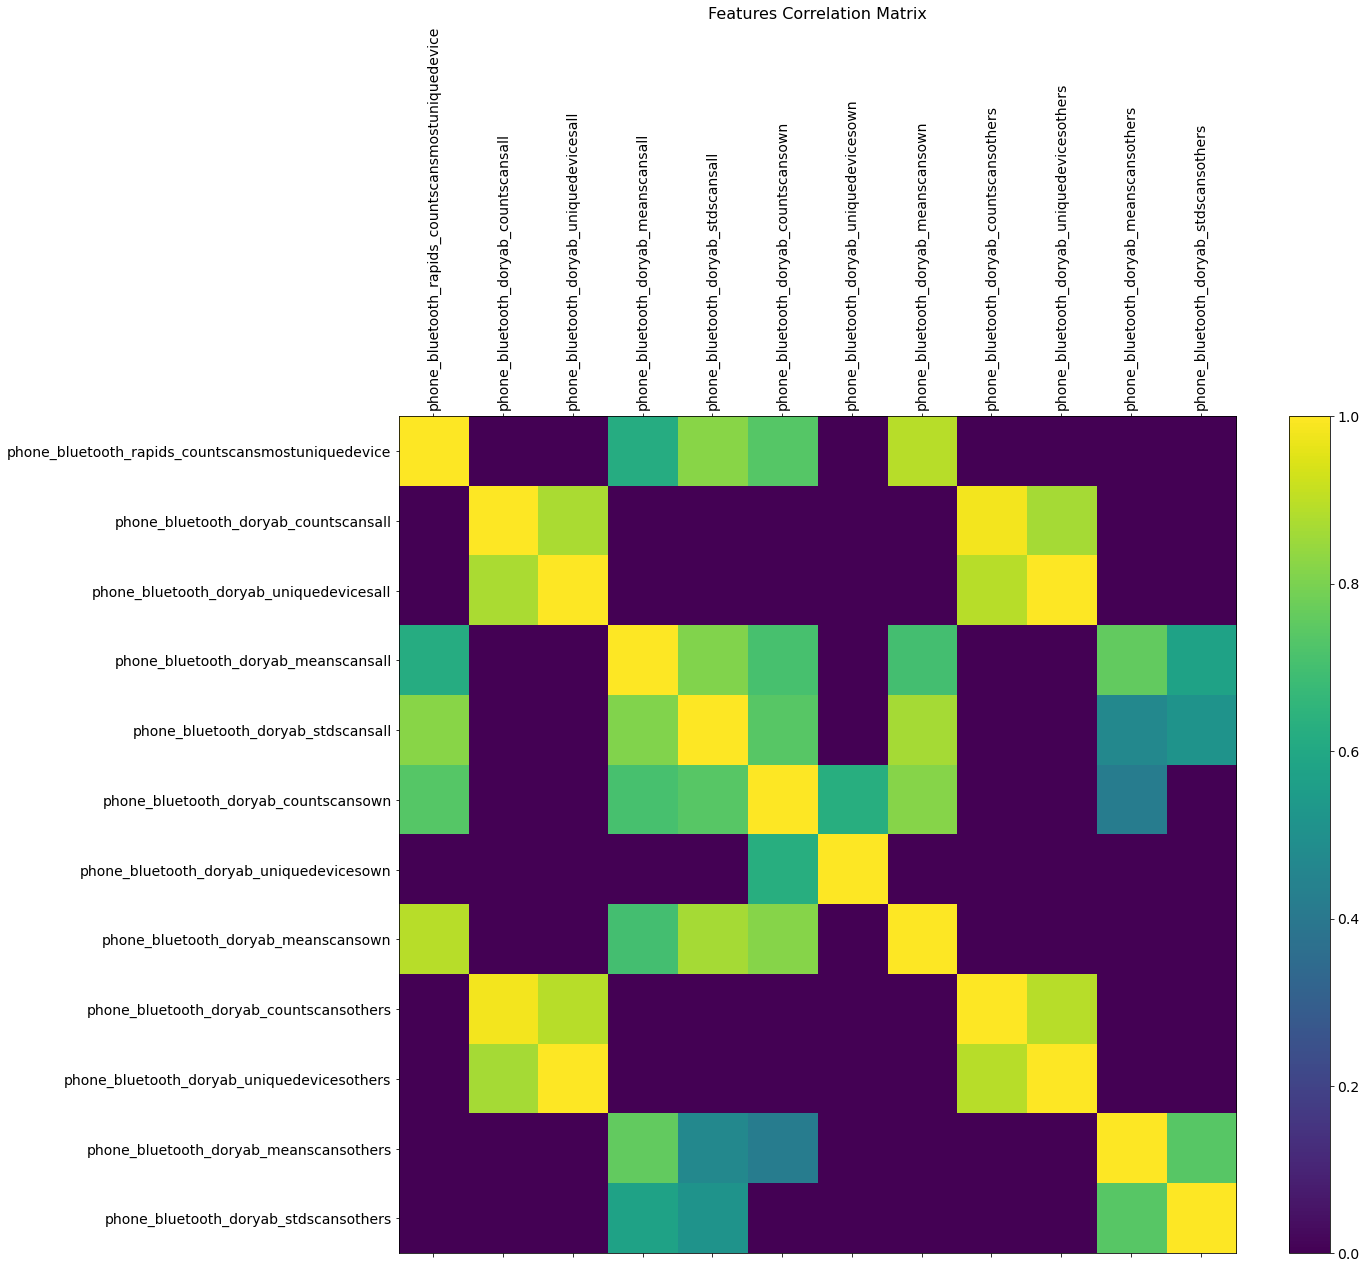

In [15]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Features Correlation Matrix', fontsize=16);
#plt.savefig('featCorrMatrix_plusminus04thres.png',bbox_inches='tight')